IMPORTS

In [1]:
import numpy
from matplotlib.pyplot import *
import matplotlib.colors as colors
from astropy.visualization import astropy_mpl_style
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
from astropy.modeling.models import Sersic2D
from astropy.cosmology import FlatLambdaCDM
from skimage import img_as_float
import imageio
from pathlib import Path
from PIL import Image
from astropy import wcs
from astropy.wcs import WCS
import matplotlib.gridspec as gridspec
from astropy.coordinates import Angle,SkyCoord
import astropy.coordinates as coord
import math
from scipy import ndimage
from astropy.convolution import discretize_model
import astropy.units as u
from scipy.stats import norm
from scipy.interpolate import RectBivariateSpline #bivariate spline approximation interpolation over a rectangular mesh grid
from photutils.detection import find_peaks
from astropy.table import Table
from astropy.stats import sigma_clipped_stats
from astropy.nddata import NDData
from photutils.psf import extract_stars
from astropy.visualization import simple_norm
from photutils.psf import EPSFBuilder
from photutils.psf import epsf_stars
import photutils.psf.epsf_stars
from photutils.psf import EPSFStar
import photutils
from astropy import convolution
from astropy.convolution import convolve
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.wcs import WCS
from photutils.isophote import EllipseGeometry, Ellipse, build_ellipse_model
from photutils.aperture import EllipticalAperture
import aplpy
from photutils.datasets import make_noise_image
import astropy.table
from astropy.io import ascii
import pandas
from astropy.utils import data
from spectral_cube import SpectralCube
import scipy.interpolate as interp
import astropy.units as u
from astropy.utils import data
from astropy.utils.data import get_pkg_data_filename
from spectral_cube import SpectralCube
from matplotlib.backends.backend_pdf import PdfPages
import sys
from reproject import reproject_interp
from scipy import signal
from scipy.signal import convolve2d
from skimage import restoration
from scipy.signal import convolve as convolve_sci
from scipy.interpolate import griddata
import pyregion

matplotlib.style.use(astropy_mpl_style)
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)#would need Ode0=0.7 if using LambdaCDM instead

%matplotlib inline

SETUP

In [2]:
#step 1: include distance ratio D_ls/D_os to the deflections alphax and alphay
#the distances here are ANGULAR DIAMETER DISTANCES - will find using astropy.cosmology
#because using ratios, will leave them in Mpc

#observer
z_obs = 0
#lens, which here is Abell 370
z_lens = 0.375
#source galaxy in the arc
z_source = 0.7251

#distance from observer to source
D_os = cosmo.angular_diameter_distance(z=z_source)
print(D_os)

#distance from lens to source
D_ls = cosmo.angular_diameter_distance_z1z2(z1=z_lens, z2=z_source)
print(D_ls)

#distance factor
Dls_over_Dos = D_ls/D_os
Dls_over_Dos = Dls_over_Dos.value
print("Dls_over_Dos = ",Dls_over_Dos)

#apply to files to get arrays for this redshift

1494.4469413490435 Mpc
645.7055560318754 Mpc
Dls_over_Dos =  0.43206991039039117


RL DECONV

In [3]:
#https://scikit-image.org/docs/stable/api/skimage.restoration.html#skimage.restoration.richardson_lucy
#https://github.com/scikit-image/scikit-image/blob/main/skimage/restoration/deconvolution.py#L355-L415
#https://github.com/scikit-image/scikit-image/blob/main/skimage/_shared/utils.py

new_float_type = {
    # preserved types
    numpy.float32().dtype.char: numpy.float32,
    numpy.float64().dtype.char: numpy.float64,
    numpy.complex64().dtype.char: numpy.complex64,
    numpy.complex128().dtype.char: numpy.complex128,
    # altered types
    numpy.float16().dtype.char: numpy.float32,
    'g': numpy.float64,      # numpy.float128 ; doesn't exist on windows
    'G': numpy.complex128,   # numpy.complex256 ; doesn't exist on windows
}

def _supported_float_type(input_dtype, allow_complex=False):

    if isinstance(input_dtype, tuple):
        return numpy.result_type(*(_supported_float_type(d) for d in input_dtype))
    input_dtype = numpy.dtype(input_dtype)
    if not allow_complex and input_dtype.kind == 'c':
        raise ValueError("complex valued input is not supported")
    return new_float_type.get(input_dtype.char, numpy.float64)

In [4]:
#https://scikit-image.org/docs/stable/api/skimage.restoration.html#skimage.restoration.richardson_lucy
#https://github.com/scikit-image/scikit-image/blob/main/skimage/restoration/deconvolution.py#L355-L415
#https://github.com/scikit-image/scikit-image/blob/main/skimage/_shared/utils.py

def richardson_lucy(image, psf, num_iter=50, clip=True, filter_epsilon=None):
#     Richardson-Lucy deconvolution.

#     Parameters
#     ----------
#     image : ndarray
#        Input degraded image (can be n-dimensional).
#     psf : ndarray
#        The point spread function.
#     num_iter : int, optional
#        Number of iterations. This parameter plays the role of
#        regularisation.
#     clip : boolean, optional
#        True by default. If true, pixel value of the result above 1 or
#        under -1 are thresholded for skimage pipeline compatibility.
#     filter_epsilon: float, optional
#        Value below which intermediate results become 0 to avoid division
#        by small numbers.

#     Returns
#     -------
#     im_deconv : ndarray
#        The deconvolved image.

    float_type = _supported_float_type(image.dtype)
    image = image.astype(float_type, copy=False)
    psf = psf.astype(float_type, copy=False)
    im_deconv = numpy.full(image.shape, 0.5, dtype=float_type)
    psf_mirror = numpy.flip(psf)

    # Small regularization parameter used to avoid 0 divisions
    eps = 1e-12

    for _ in range(num_iter):
        conv = convolve_sci(im_deconv, psf, mode='same') + eps
        if filter_epsilon:
            relative_blur = numpy.where(conv < filter_epsilon, 0, image / conv)
        else:
            relative_blur = image / conv
        im_deconv *= convolve_sci(relative_blur, psf_mirror, mode='same')

    if clip:
        im_deconv[im_deconv > 1] = 1
        im_deconv[im_deconv < -1] = -1

    return im_deconv

REPROJECT INTERPOLATE

In [5]:
#project and trim, for one map at a time, new code addition 2024

def project_on_data_and_trim(file_name_and_path,output0,output1,data_image='/mnt/c/Users/lana-/Desktop/hlsp_frontier_hst_acs-30mas-selfcal_abell370_f814w_v1.0-epoch1_drz.fits'):

    print("here")
    #READ IN EVERYTHING IN A CONCISE MANNER
    basename_for_maps = file_name_and_path
    hdu_given_file = fits.open(get_pkg_data_filename(basename_for_maps))[0]
    print("here")
    #data image from HFF
    hdu_HFF_814 = fits.open(get_pkg_data_filename(data_image))[0]
    print("here")
    #REPROJECT EVERYTHING PROPERLY onto the larger HFF data grid
    data_resolution_reproj, footprint_on_data = reproject_interp(hdu_given_file, hdu_HFF_814.header)
    print("here")
    #get rid of nans
    data_resolution_reproj[numpy.isnan(data_resolution_reproj)] = 0.0
    print("here")
    #save file
    fits.writeto(output0, data_resolution_reproj, hdu_HFF_814.header, overwrite=True)
    print("here")

    #cutout section for the maps
    hdu_data_resolution = fits.open(output0)[0]
    wcs_data_resolution = WCS(hdu_data_resolution.header)
    print("here")
    # Make the cutout, including the WCS
    #Specify the reference position as an astropy SkyCoord object
    fieldcenter = SkyCoord('02h39m52.9s','-01d34m36.5s')
    data_resolution_fits_cutout = Cutout2D(hdu_data_resolution.data, position=fieldcenter, size=(3001,3001), wcs=wcs_data_resolution)
    print("here")
    # Put the cutout image in the FITS HDU
    hdu_data_resolution.data = data_resolution_fits_cutout.data
    print("here")
    # Update the FITS header with the cutout WCS
    hdu_data_resolution.header.update(data_resolution_fits_cutout.wcs.to_header())
    print("here")
    hdu_data_resolution.writeto(output1, overwrite=True)
    print("here")



In [6]:
# project_on_data_and_trim(file_name_and_path='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/fid2d_edit_lensmodel_x-arcsec-deflect.fits',output0='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/x_out0.fits',output1='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/x_out_reproj_trim.fits')
# project_on_data_and_trim(file_name_and_path='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/fid2d_edit_lensmodel_y-arcsec-deflect.fits',output0='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/y_out0.fits',output1='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/y_out_reproj_trim.fits')


DECONVOLVE RL W/PSF

In [7]:
#read in and deconvolve - need to do this for left image to calculate with + for entire arc to calculate residuals

def deconvolve_data_im(data_im,psf_file):

    data_arc_left = fits.open(data_im)[0] #full or not
    epsf_red = fits.open(psf_file)[0]
    deconvolved_RL = richardson_lucy(data_arc_left.data, epsf_red.data, num_iter=10)

    return data_arc_left, deconvolved_RL



In [8]:
data_arc_left, deconvolved_RL = deconvolve_data_im(data_im='/mnt/c/Users/lana-/Desktop/Correct_Coordinates/data_cutout_814_full.fits',psf_file='/mnt/c/Users/lana-/Desktop/Correct_Coordinates/arc_source_814.psf.fits')


Text(0.5, 1.0, 'Residuals?  What PSF adds')

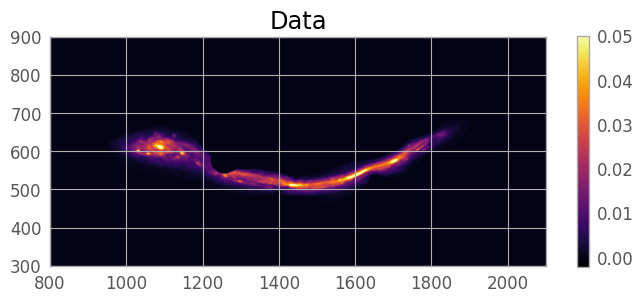

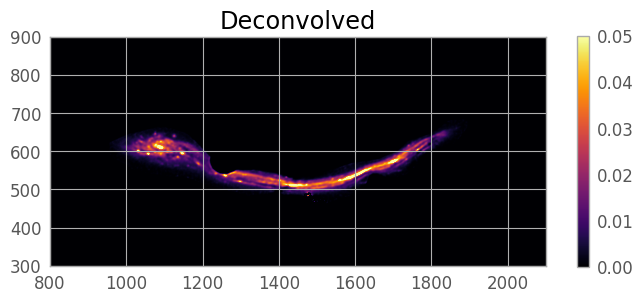

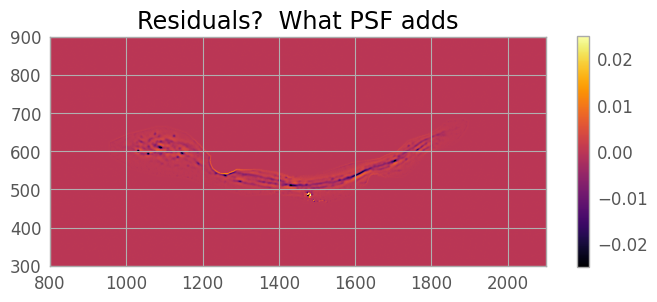

In [9]:
#now plot what I just calculated

figure(15)
imshow(data_arc_left.data,origin='lower',cmap='inferno',vmax=0.05)
colorbar(shrink=0.5)
xlim(800,2100)
ylim(300,900)
title('Data')

figure(16)
imshow(deconvolved_RL,origin='lower',cmap='inferno',vmin=0.,vmax=0.05)
colorbar(shrink=0.5)
xlim(800,2100)
ylim(300,900)
title('Deconvolved')

figure(17)
imshow(data_arc_left.data - deconvolved_RL,origin='lower',cmap='inferno',vmin=-0.025,vmax=0.025)
colorbar(shrink=0.5)
xlim(800,2100)
ylim(300,900)
title('Residuals?  What PSF adds')


MASK ARC

Text(0.5, 1.0, 'Deconvolved with Richardson-Lucy, Masked')

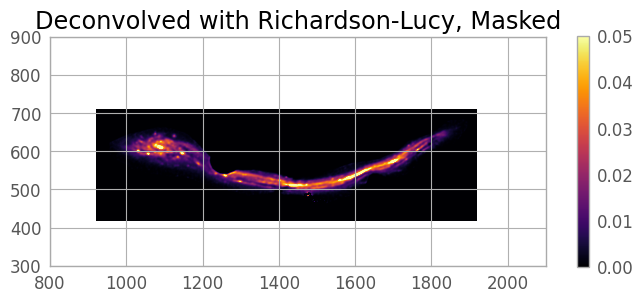

In [10]:
#now need to mask

zero_masks = 1.*deconvolved_RL
arc_to_mask = 1.*deconvolved_RL

#rectangle - for the entire arc
for p in range(1000):
    for q in range(300):
        zero_masks[q+415][p+920] = 50000000.

#https://pyregion.readthedocs.io/en/latest/getting_started.html
#compare to using region file to mask parts of arc with no shadows from removed galaxies (which is a separate problem - for now, just avoid)

arc_to_mask[numpy.where(zero_masks!=50000000.)] = numpy.nan


figure(18)
imshow(arc_to_mask,origin='lower',cmap='inferno',vmin=0.,vmax=0.05)
colorbar(shrink=0.5)
xlim(800,2100)
ylim(300,900)
title('Deconvolved with Richardson-Lucy, Masked')


DELENS DATA

In [11]:
#write out opposite - function to de-lens an image using 1) image input and 2) x and y deflection maps input
#first try before PSF convolution, so on the model arc without the PSF convolution
#then incorporate the PSF deconvolution

#write out function to lens a source using 1) source input and 2) x and y deflection maps input

def delens_left_image_to_source(output_file,data_image='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/data_square_final.fits',input_alphax='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/x_out_reproj_trim.fits',input_alphay='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/y_out_reproj_trim.fits',left_im_only=0):

    #READ IN SOME FILES
    #all below are with the grid resolution of the HFF data image

    #alphax deflection map
    alphax_fits = fits.getdata(input_alphax)

    #alphay deflection map
    alphay_fits = fits.getdata(input_alphay)

    arc_map = arc_to_mask
    grid_hdu = fits.open(get_pkg_data_filename(data_image))[0]

    #REPROJECT ONTO GRID

    #need to interpret model arc we previously created as function interpolated onto a grid
    #shape of the grid on which we will compute the arc
    #make the grid of coordinates
    coord_x = numpy.arange(0,arc_map.shape[0])
    coord_y = numpy.arange(0,arc_map.shape[1])
    X,Y = numpy.meshgrid(coord_x,coord_y)#,indexing='ij')
    #now do the interpolation to create a function!
    arc_function = interp.RegularGridInterpolator((coord_y,coord_x), arc_map, bounds_error=False)
    arc_interp = arc_function((Y,X))
    #plot this
    figure(figsize=(10,10))
    imshow(arc_interp,origin='lower',cmap='inferno',vmax=0.05)
    title("Interpolated Arc Image Function on Grid")


    #DELENS IMAGE INTO SOURCE PLANE

    #apply the Dls_over_Dos scaling
    #(5/90000) degrees per pixel // (1/3600) degrees per arcsecond // alpha is in arcseconds
    cr_value = grid_hdu.header['CD2_2']
    alphax = Dls_over_Dos*alphax_fits/(cr_value*3600.)#*(90000./(5.*3600.))
    alphay = Dls_over_Dos*alphay_fits/(cr_value*3600.)#*(90000./(5.*3600.))
    
    #interpolate the irregular grid data onto a regular grid
    #use scipy.interpolate.griddata https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
    #need to figure out if this conserves surface brightness
    if left_im_only==1:
        #need to set up arrays
        #first set up 2D ndarray of coordinates for all the delensed points
        #maybe make this blank first, then go through the for loop and input them for each index

        #next set up an ndarray of brightness values for all of those delensed points
        #maybe make this blank first, then go through the for loop and input them for each index

        rng = numpy.random.default_rng()

        #want to interpolate our 2D source "function"
        #on a grid - with this shape
        x_coord = numpy.arange(0,arc_map.shape[0])
        y_coord = numpy.arange(0,arc_map.shape[1])
        grid_x,grid_y = numpy.meshgrid(x_coord,y_coord)#,indexing='ij')
        #grid_x, grid_y = numpy.mgrid[1200:1360:160j, 1000:1120:120j] #based on the size of the desired source grid
        #but we only know its values at the delensed points - put the values in an array
        points_2D_arr = 0.*rng.random((61200, 2)) #need this for the coordinates of each pixel we delens; probably not the best way to do this, but I want to make sure it has the right shape
        values_1D_arr = numpy.zeros(61200)#this should just be an array of 61200 values, and set to zero to start
        # print(values_1D_arr)
        # print(len(values_1D_arr))
        # print(numpy.shape(values_1D_arr))
        #now de-lens each pixel and store the coordinates and values separately
        count = -1
        for p in range(340):
            for q in range(180):
                count = count + 1
                # print(p+q)
                #need to take each pixel in the image plane
                #arc_map[x][y] - this is a value
                #store the brightness values in the empty grid that we had, indexing just one by one
                values_1D_arr[count] = arc_map[q+520][p+920]
                #add the deflection from the alpha maps at that point, alphax to x, alphay to y
                #alphax[x][y] - this adjusts the pixel location
                new_x = (p+920) - alphax[q+520][p+920]
                #alphay[x][y] - this adjusts the pixel location
                new_y = (q+520) - alphay[q+520][p+920]
                #now store the coordinates in the empty grid that we had, indexing just one by one
                points_2D_arr[count][0] = new_x
                points_2D_arr[count][1] = new_y
        print("points_2D_arr",points_2D_arr)
        print(len(points_2D_arr))
        print(numpy.shape(points_2D_arr))
        print("values_1D_arr",values_1D_arr)
        print(len(values_1D_arr))
        print(numpy.shape(values_1D_arr))
        source_irreg_interp = griddata(points_2D_arr, values_1D_arr, (grid_x, grid_y), method="linear") #nearest, linear, cubic
        src_model = source_irreg_interp#.transpose()#*1.


    #interpolate the irregular grid data onto a regular grid
    #use scipy.interpolate.griddata https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html
    #need to figure out if this conserves surface brightness
    if left_im_only==0: #FOR THE WHOLE ARC
        #need to set up arrays
        #first set up 2D ndarray of coordinates for all the delensed points
        #maybe make this blank first, then go through the for loop and input them for each index

        #next set up an ndarray of brightness values for all of those delensed points
        #maybe make this blank first, then go through the for loop and input them for each index

        rng = numpy.random.default_rng()

        #want to interpolate our 2D source "function"
        #on a grid - with this shape
        x_coord = numpy.arange(0,arc_map.shape[0])
        y_coord = numpy.arange(0,arc_map.shape[1])
        grid_x,grid_y = numpy.meshgrid(x_coord,y_coord)#,indexing='ij')
        #grid_x, grid_y = numpy.mgrid[1200:1360:160j, 1000:1120:120j] #based on the size of the desired source grid
        #but we only know its values at the delensed points - put the values in an array
        points_2D_arr = 0.*rng.random((300000, 2)) #need this for the coordinates of each pixel we delens; probably not the best way to do this, but I want to make sure it has the right shape
        values_1D_arr = numpy.zeros(300000)#this should just be an array of 61200 values, and set to zero to start
        # print(values_1D_arr)
        # print(len(values_1D_arr))
        # print(numpy.shape(values_1D_arr))
        #only if also checking out the bad pixels:
        # if just_want_orig_pix==1:
        #     #also make an array to store the weird points
        #     strange_pix = 0.*arc_map
        #now de-lens each pixel and store the coordinates and values separately
        count = -1
        for p in range(1000):
            for q in range(300):
                count = count + 1
                # print(p+q)
                #need to take each pixel in the image plane
                #arc_map[x][y] - this is a value
                #store the brightness values in the empty grid that we had, indexing just one by one
                values_1D_arr[count] = arc_map[q+415][p+920]
                #add the deflection from the alpha maps at that point, alphax to x, alphay to y
                #alphax[x][y] - this adjusts the pixel location
                new_x = (p+920) - alphax[q+415][p+920]
                #alphay[x][y] - this adjusts the pixel location
                new_y = (q+415) - alphay[q+415][p+920]
                #now store the coordinates in the empty grid that we had, indexing just one by one
                points_2D_arr[count][0] = new_x
                points_2D_arr[count][1] = new_y

        source_irreg_interp = griddata(points_2D_arr, values_1D_arr, (grid_x, grid_y), method="linear") #nearest, linear, cubic
        src_model = source_irreg_interp#.transpose()#*1.


    figure(figsize=(10,10))#this should plot the source
    imshow(src_model,origin='lower',cmap='inferno',vmin=0.,vmax=0.05)#,interpolation='nearest',cmap='inferno',vmin=0.0,vmax=1.5,alpha=0.75,zorder=14)
    colorbar()

    figure(figsize=(10,10))
    imshow(src_model,origin='lower',cmap='inferno',vmin=0.,vmax=0.05)#,interpolation='nearest',cmap='inferno',vmin=0.0,vmax=1.5,alpha=0.75,zorder=14)
    colorbar()
    xlim(1200,1350)
    ylim(1000,1125)
    title("Deconvolved & De-Lensed Arc")

    fits.writeto(output_file, src_model, grid_hdu.header, overwrite=True)

    return arc_interp, src_model#, strange_pix



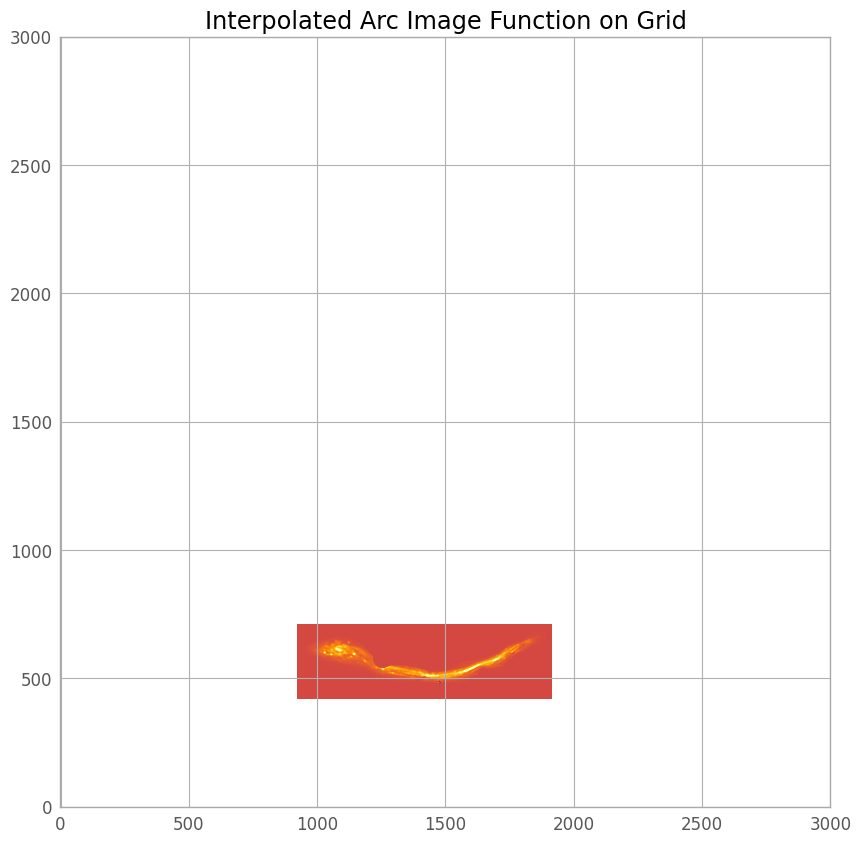

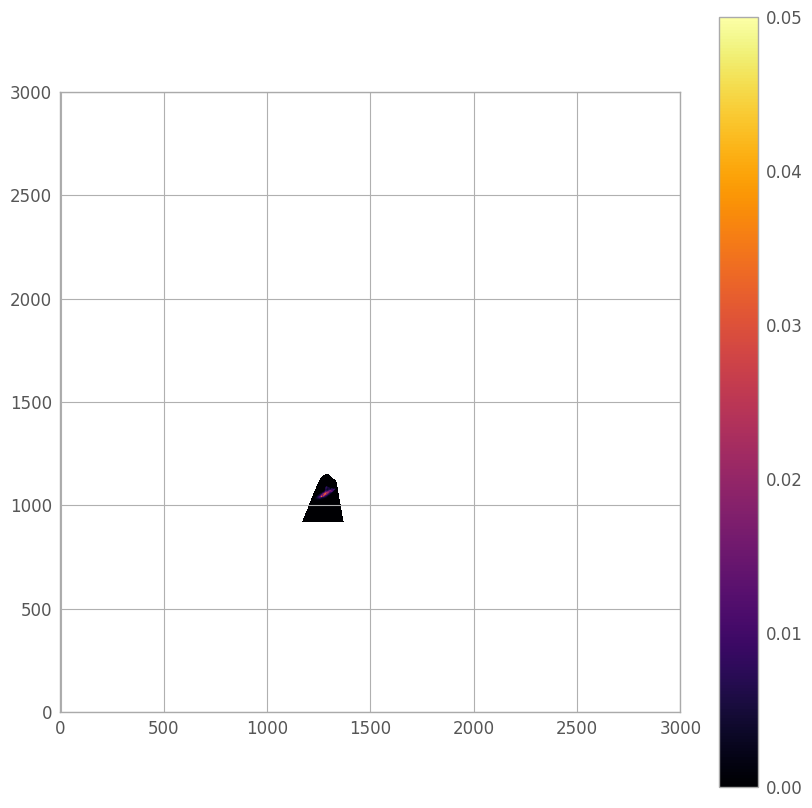

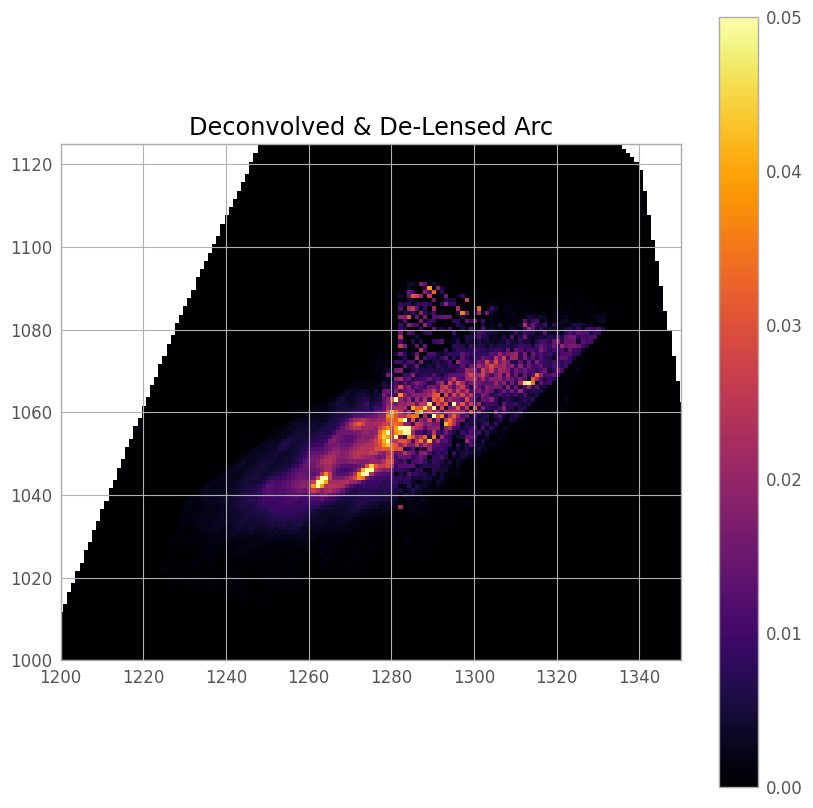

In [12]:
#arc_interp, src_model = delens_left_image_to_source(indx=2,method_delens=1)
arc_interp, src_model = delens_left_image_to_source(output_file='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/delensed_source.fits',data_image='/mnt/c/Users/lana-/Desktop/Correct_Coordinates/data_cutout_814_full.fits',input_alphax='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/x_out_reproj_trim.fits',input_alphay='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/y_out_reproj_trim.fits',left_im_only=0)


MASK SOURCE

Text(0.5, 1.0, 'Source Mask')

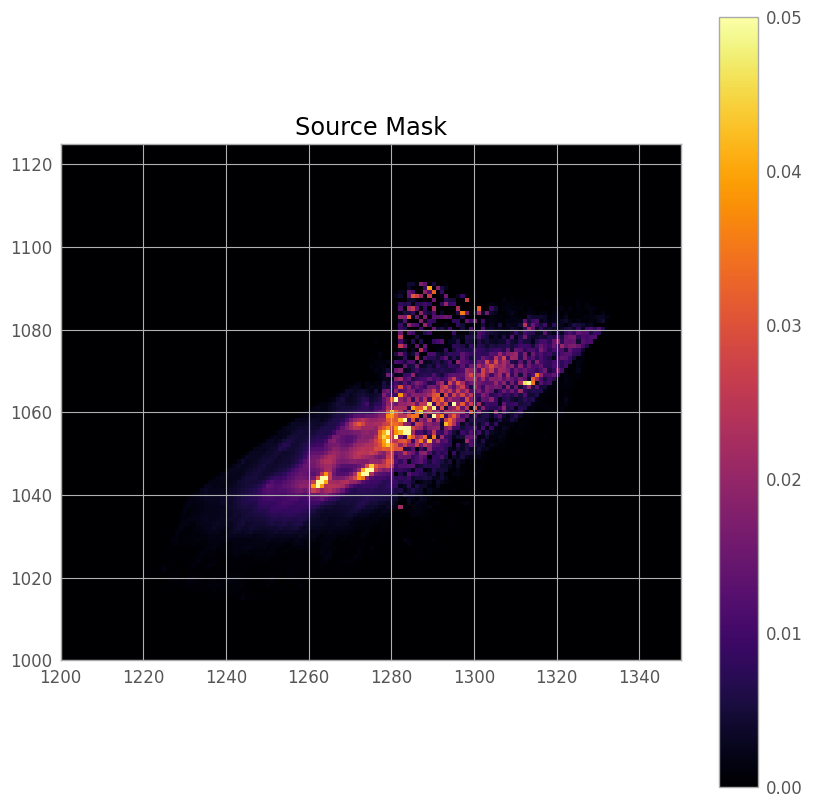

In [13]:
#mask the source now

zero_masks = 1.*src_model
source_to_mask = 1.*src_model

#set up indices where do not want
for p in range(150):
    for q in range(125):
        zero_masks[q+1000][p+1200] = 50000000.

#edit the source map to include only the region that we want to use
source_to_mask[numpy.where(zero_masks!=50000000.)] = numpy.nan
source_to_mask[numpy.where(src_model==0.)] = numpy.nan
source_to_mask[numpy.isnan(source_to_mask)] = 0.

figure(figsize=(10,10))
imshow(source_to_mask,origin='lower',cmap='inferno',vmin=0.,vmax=0.05)
colorbar()
xlim(1200,1350)
ylim(1000,1125)
title('Source Mask')

RE-LENS DE-LENSED SOURCE

In [14]:
#write out function to lens a source using 1) source input and 2) x and y deflection maps input

def lens_delensedsource_to_image(output_file0,output_file1,mag_yes=0,input_alphax='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/x_out_reproj_trim.fits',input_alphay='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/y_out_reproj_trim.fits'):

    #READ IN SOME FILES
    #all below are with the grid resolution of the HFF data image

    #source - deconvolved and delensed source from python, on data grid
    source_array_hi = src_model

    #alphax deflection map
    alphax_fits = fits.getdata(input_alphax)

    #alphay deflection map
    alphay_fits = fits.getdata(input_alphay)

    # #kappa map
    # kappa_fits = fits.open(get_pkg_data_filename('/mnt/c/Users/lana-/Desktop/Correct_Coordinates/Proper_Tests/maps_on_data_cutouts/kappa_reproject_{:03d}.fits'.format(indx)))[0]
       
    # #gamma map
    # gamma_fits = fits.open(get_pkg_data_filename('/mnt/c/Users/lana-/Desktop/Correct_Coordinates/Proper_Tests/maps_on_data_cutouts/gamma_reproject_{:03d}.fits'.format(indx)))[0]
        

    #PLOT SOURCE
    figure(figsize=(10,10))
    imshow(source_array_hi, origin='lower',cmap='magma',vmin=0.,vmax=0.05)#, vmin=-2.e-4, vmax=5.e-4)
    title('Deconvolved and Delensed Source Image on HFF Data Grid')
    colorbar()

    #now rename what I need

    source_map = source_to_mask#src_model#fits.getdata(basename_for_maps+'left_arc_maps/source_hi_{:03d}.fits'.format(indx))
    grid_hdu = fits.open(get_pkg_data_filename('/mnt/c/Users/lana-/Desktop/Correct_Coordinates/data_cutout_814_full.fits'))[0]

    #TURN SOURCE INTO FUNCTION


    #now need to interpolate onto a grid
    #shape of the grid on which we will compute the arc
    #make the grid of coordinates
    coord_x = numpy.arange(0,source_map.shape[0])
    coord_y = numpy.arange(0,source_map.shape[1])
    X,Y = numpy.meshgrid(coord_x,coord_y)#,indexing='ij')
    #now do the interpolation to create a function!
    source_function = interp.RegularGridInterpolator((coord_y,coord_x), source_map, bounds_error=False)
    source_interp = source_function((Y,X))#strange_pix
    #plot this
    figure(figsize=(10,10))
    imshow(source_interp,origin='lower',cmap='inferno',vmin=0.,vmax=0.05)
    title("Interpolated Source Function on Grid")
    colorbar()

    #LENS SOURCE INTO IMAGE PLANE

    #apply the Dls_over_Dos scaling and convert the deflections to the correct units
    #(5/90000) degrees per pixel // (1/3600) degrees per arcsecond // alpha is in arcseconds
    cr_value = grid_hdu.header['CD2_2']
    alphax = Dls_over_Dos*alphax_fits/(cr_value*3600.)#*(90000./(5.*3600.))
    alphay = Dls_over_Dos*alphay_fits/(cr_value*3600.)#*(90000./(5.*3600.))
    # kappa = Dls_over_Dos*kappa_fits.data
    # gamma = Dls_over_Dos*gamma_fits.data


    #shape of the grid on which we will compute the arc
    mmm,nnn = alphax_fits.shape
    #pixel grid
    iii,jjj = numpy.meshgrid(numpy.arange(0,mmm),numpy.arange(0,nnn), indexing='xy')


    #image setup
    #pix2xy turns the pixels into arcseconds..
    a,b = iii,jjj#pix2xy(iii,jjj,wcs_info)
    #plug the positions and deflections into the source function to get the image
    x = a - alphax
    y = b - alphay
    #image grid
    image_grid = source_function((y,x))
    #want to ignore unphysical bright spots in the source reconstructions
    #maybe cut off at above 0.1
    # image_grid[numpy.where(image_grid>0.1)] = 0.0#numpy.nan
    #image_grid[numpy.where(image_grid<1)] = numpy.nan
    img_model = image_grid

    figure(figsize=(10,10))
    imshow(img_model,origin='lower',cmap='inferno',vmin=0.,vmax=0.05)#,interpolation='nearest',cmap='inferno',vmin=0.0,vmax=1.5,alpha=0.75,zorder=14)
    title("Relensed Arc, Plain")
    colorbar(shrink=0.5)
    xlim(800,2100)
    ylim(300,900)

    fits.writeto(output_file0, img_model, grid_hdu.header, overwrite=True) #this used to use hdu_alphax, but I am now setting it to source_map, which is the new/larger/reprojected grid size
    hdu_left_im_arc = fits.open(output_file0)[0]
    wcs_left_im_arc = WCS(hdu_left_im_arc.header)

    #CONVOLVE - FOR LATER

    #read in files
    # data_arc = fits.getdata(basename_for_maps+'arc_maps/data_arc_{:03d}.fits'.format(indx))
    left_im_arc = fits.getdata(output_file0)

    epsf_red = fits.open('/mnt/c/Users/lana-/Desktop/Correct_Coordinates/arc_source_814.psf.fits')[0]

    left_im_arc_psf_conv = convolve(left_im_arc,epsf_red.data)

    #create a PrimaryHDU object to encapsulate the data:
    left_im_arc_hdu_conv = fits.PrimaryHDU(left_im_arc_psf_conv)
    #then create an HDUList to contain the newly created primary HDU and write to a new file:
    left_im_arc_hdu_conv_hdu = fits.HDUList([left_im_arc_hdu_conv])
    left_im_arc_hdu_conv_hdu.writeto(output_file0, overwrite=True)
    #need to update wcs, not sure if best way
    left_im_arc_conv = fits.open(output_file0)
    conv_wcs_update = left_im_arc_conv[0].header
    conv_wcs_update = hdu_left_im_arc.header
    left_im_arc_conv[0].header = hdu_left_im_arc.header
    left_im_arc_conv.writeto(output_file0, overwrite=True)


    figure(figsize=(10,10))
    imshow(left_im_arc_psf_conv,origin='lower',cmap='inferno',vmin=0.,vmax=0.05)#,interpolation='nearest',cmap='inferno',vmin=0.0,vmax=1.5,alpha=0.75,zorder=14)
    title("Re-Lensed Arc, PSF Convolution")
    colorbar(shrink=0.5)
    xlim(800,2100)
    ylim(300,900)


    data_arc_mask = fits.open(get_pkg_data_filename('/mnt/c/Users/lana-/Desktop/Correct_Coordinates/data_cutout_814_full.fits'))[0]
    residuals_arc = data_arc_mask.data - left_im_arc_psf_conv

    figure(figsize=(10,10))
    imshow(residuals_arc,origin='lower',cmap='twilight',vmin=-0.05,vmax=0.02)#,interpolation='nearest',cmap='inferno',vmin=0.0,vmax=1.5,alpha=0.75,zorder=14)
    title("Residuals Data Arc - Deconvolved/Delensed/Lensed/Reconvolved Arc")
    colorbar(shrink=0.5)
    xlim(800,2100)
    ylim(300,900)

    fits.writeto(output_file1, residuals_arc, grid_hdu.header, overwrite=True) #this used to use hdu_alphax, but I am now setting it to source_map, which is the new/larger/reprojected grid size

    # if mag_yes==1:
        
    #     #calculate the magnification maps
    #     mu_mag_signed = 1.0/(((1.0-kappa)**2)-(gamma**2))
    #     mu_mag_plot_unsigned = numpy.log10(numpy.abs(mu_mag_signed))

    #     figure(figsize=(10,10))
    #     imshow(mu_mag_plot_unsigned,origin='lower',cmap='viridis')#,alpha=0.5)
    #     imshow(strange_pix,origin='lower',cmap='inferno',vmin=0.,vmax=0.02,alpha=0.5)#,interpolation='nearest',cmap='inferno',vmin=0.0,vmax=1.5,alpha=0.75,zorder=14)
    #     title("Mag Map, Re-Lensed (Left) Arc, PSF Convolution")
    #     colorbar(shrink=0.5)
    #     xlim(800,2100)
    #     ylim(300,900)

    #     #want to plot caustics along source and critical curves along images

    #     #specify map info
    #     npix = 3001
    #     xmax = 300 #arcsec?  what is this number for?
    #     pixscale = 2*xmax/(npix-1) #this was 0.2 in the original

    #     #read and extract deflection maps
    #     defx_fits = fits.open(basename_for_maps+'maps_on_data_cutouts/alphax_hi_cutout_{:03d}.fits'.format(indx))
    #     defx = defx_fits[0]
    #     defy_fits = fits.open(basename_for_maps+'maps_on_data_cutouts/alphay_hi_cutout_{:03d}.fits'.format(indx))
    #     defy = defy_fits[0].data

    #     #read and extract magnification map
    #     mag = mu_mag_signed

    #     #set up position grids
    #     tmp = -xmax + pixscale*numpy.arange(npix)
    #     xx,yy = numpy.meshgrid(tmp,tmp)

    #     #compute source position "grids"
    #     uu = xx - defx
    #     vv = yy - defy

    #     #set up interpolation for deflections, using indices
    #     tmp2 = numpy.arange(npix)
    #     defx_interp = RectBivarateSpline(tmp2,tmp2,defx)
    #     defy_interp = RectBivarateSpline(tmp2,tmp2,defy)

    #     #now to get critical curves, where mag goes from + to -, and define caustics

    #     #get the contours where 1/mag=0 (this is python magic!)
    #     cnt = contour(1.0/mag,[0])

    #     #process into list of critical curves and caustics

    #     #first initialize empty lists
    #     allcrit = []
    #     allcaus = []

    #     #loop over all "segments" in the contour plot
    #     for v in cnt.allsegs[0]:
    #         #convert from pixel units to arcsec in image plane
    #         x = -xmax + pixscale*v[:,0]
    #         y = -xmax + pixscale*v[:,1]
    #         #interpolate deflections and map to source plane
    #         #take note of the order of indices in the interpolation
    #         u = x - defx_interp.ev(v[:,1],v[:,0])
    #         v = y - defy_interp.ev(v[:,1],v[:,0])
    #         #add to the lists
    #         allcrit.append([x,y])
    #         allcaus.append([u,v])

    #     #plot with all one color
    #     f,ax = subplots(1,2,figsize=(16,8))
    #     for i in range(len(allcrit)):
    #         x,y = allcrit[i]
    #         u,v = allcaus[i]
    #         x_new = (x+xmax)/pixscale-30
    #         y_new = (y+xmax)/pixscale-30
    #         u_new = (u+xmax)/pixscale-30
    #         v_new = (v+xmax)/pixscale-30
    #         ax[0].plot(x_new,y_new,zorder=2)
    #         ax[1].plot(u_new,v_new,zorder=3)
    #     ax[0].set_xlabel('former label - not arcsec')
    #     ax[0].set_ylabel('former label - not arcsec')
    #     ax[1].set_xlabel('former label - not arcsec')
    #     ax[1].set_ylabel('former label - not arcsec')
    #     ax[0].set_title('critical curves')
    #     ax[1].set_title('caustics')
    #     f.show()

    #     #plot with ..all the colors?
    #     #plot everything using subplots so can see zoomed out and zoomed in areas
    #     f,ax = subplots(2,2,figsize=(15,10))
    #     #sets up number of boundaries between color sections
    #     mag_bounds = [0.0, 0.5, 0.8, 1.0, 1.5, 1.8, 2]
    #     #sets up the normalization for the colormap
    #     norm = colors.BoundaryNorm(boundaries=mag_bounds, ncolors=256)
    #     #changed this from subplots 2,1 above and for i in range(2): ax[i].imshow etc
    #     for a in ax:
    #         for b in a:
    #             #rgb image
    #             rgb_im = b.imshow(mag,origin='lower',alpha=1,zorder=0)
    #             # magnification map
    #             #magmap = b.imshow(mu_plot,origin='lower',norm=norm,cmap='inferno',vmin=0.250,vmax=2.0,alpha=0.5,zorder=1)
    #     for i in range(len(allcrit)):
    #         x,y = allcrit[i]
    #         u,v = allcaus[i]
    #         ax[0][0].plot((x+xmax)/pixscale,(y+xmax)/pixscale,color='yellow',zorder=2)#changed from lime
    #         ax[0][0].plot((u+xmax)/pixscale,(v+xmax)/pixscale,color='orange',zorder=3)#changed from aqua to orange
    #         ax[0][1].plot((x+xmax)/pixscale,(y+xmax)/pixscale,color='yellow',zorder=4)
    #         ax[0][1].plot((u+xmax)/pixscale,(v+xmax)/pixscale,color='orange',zorder=5)
    #         ax[1][0].plot((x+xmax)/pixscale,(y+xmax)/pixscale,color='yellow',zorder=6)
    #         ax[1][0].plot((u+xmax)/pixscale,(v+xmax)/pixscale,color='orange',zorder=7)
    #         ax[1][1].plot((x+xmax)/pixscale,(y+xmax)/pixscale,color='yellow',zorder=8)
    #         ax[1][1].plot((u+xmax)/pixscale,(v+xmax)/pixscale,color='orange',zorder=9)
        
    #     #set bounds for colorbar sections
    #     bounds = [0, 0.4, 1.0, 5]
    #     cmap_sections = colors.ListedColormap(['dodgerblue','lime','red'])
            
    #     #source
    #     src1 = ax[0][0].imshow(numpy.log10(src_model),origin='lower',interpolation='nearest',cmap=cmap_sections,vmin=0.0,vmax=1.5,alpha=0.75,zorder=10)#,vmin=vmin[i])#edit vmin and vmax
    #     src11 = ax[1][0].imshow(numpy.log10(src_model),origin='lower',interpolation='nearest',cmap=cmap_sections,vmin=0.0,vmax=1.5,alpha=0.75,zorder=11)#,vmin=vmin[i])#edit vmin and vmax
    #     #ave source
    #     src2 = ax[0][1].imshow(numpy.log10(src_model),origin='lower',interpolation='nearest',cmap=cmap_sections,vmin=0.0,vmax=1.5,alpha=0.75,zorder=12)#,vmin=vmin[i])#edit vmin and vmax
    #     src22 = ax[1][1].imshow(numpy.log10(src_model),origin='lower',interpolation='nearest',cmap=cmap_sections,vmin=0.0,vmax=1.5,alpha=0.75,zorder=13)#,vmin=vmin[i])#edit vmin and vmax

    #     #arc
    #     img1 = ax[0][0].imshow(numpy.log10(img_model),origin='lower',interpolation='nearest',cmap=cmap_sections,vmin=0.0,vmax=1.5,alpha=0.75,zorder=14)#edit vmin and vmax
    #     img11 = ax[1][0].imshow(numpy.log10(img_model),origin='lower',interpolation='nearest',cmap=cmap_sections,vmin=0.0,vmax=1.5,alpha=0.75,zorder=15)#edit vmin and vmax
    #     #ave arc
    #     img2 = ax[0][1].imshow(numpy.log10(img_model),origin='lower',interpolation='nearest',cmap=cmap_sections,vmin=0.0,vmax=1.5,alpha=0.75,zorder=16)#edit vmin and vmax
    #     img22 = ax[1][1].imshow(numpy.log10(img_model),origin='lower',interpolation='nearest',cmap=cmap_sections,vmin=0.0,vmax=1.5,alpha=0.75,zorder=17)#edit vmin and vmax
                
    #     ax[0][0].set_xlim([450,675])
    #     ax[0][0].set_ylim([375,600])
    #     ax[0][1].set_xlim([450,675])
    #     ax[0][1].set_ylim([375,600])
    #     ax[1][0].set_xlim([525,575])
    #     ax[1][0].set_ylim([485,530])
    #     ax[1][1].set_xlim([525,575])
    #     ax[1][1].set_ylim([485,530])
    #     ax[1][0].set_title('map{:03d}'.format(indx))
    #     ax[1][1].set_title('map{:03d}'.format(indx))
    #     f.tight_layout()

    return source_interp,img_model,left_im_arc_psf_conv


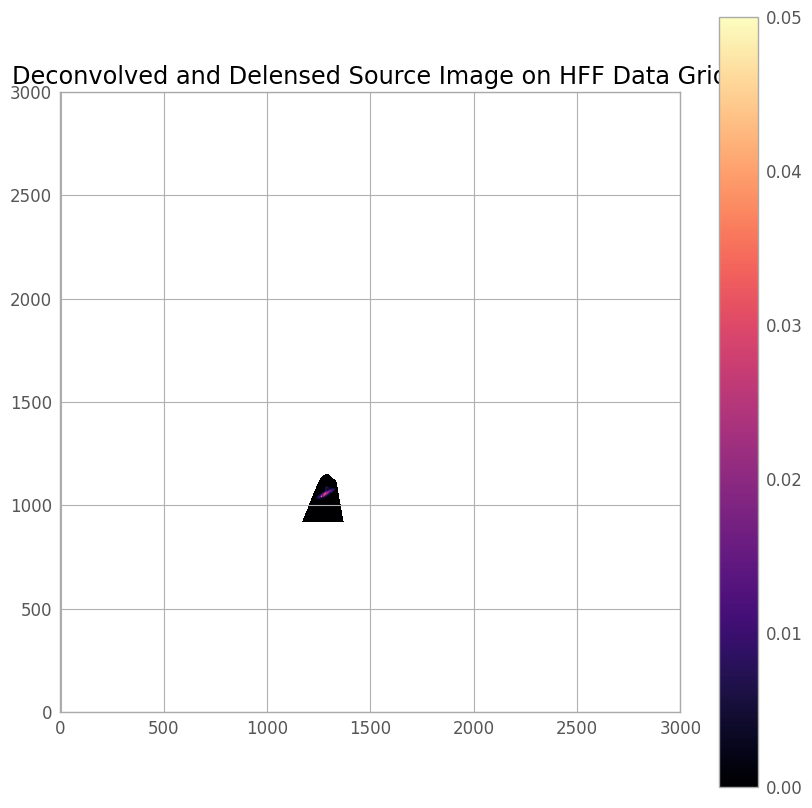

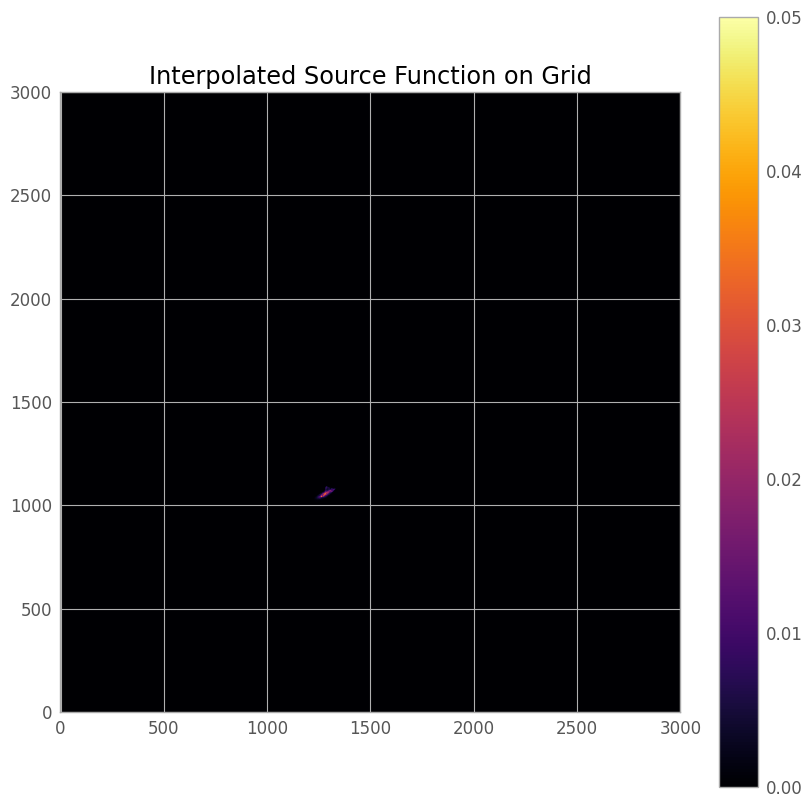

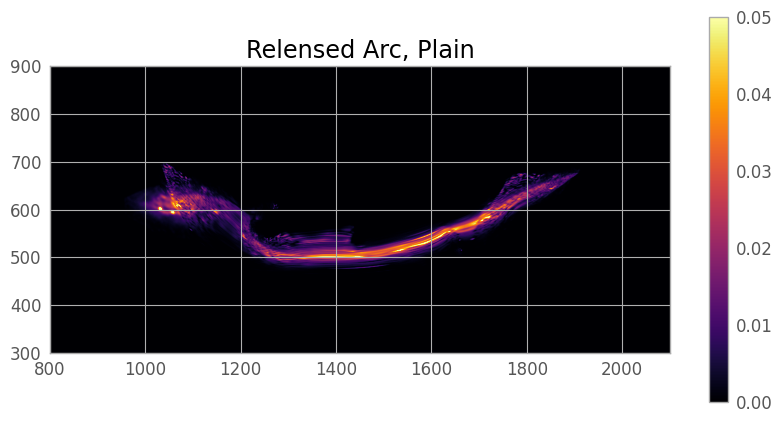

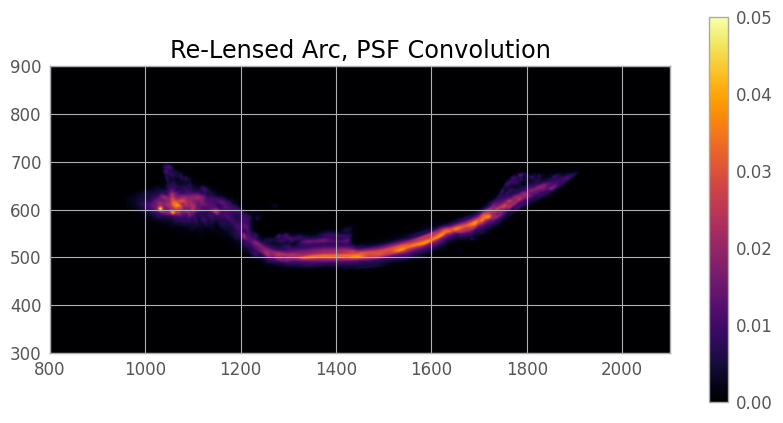

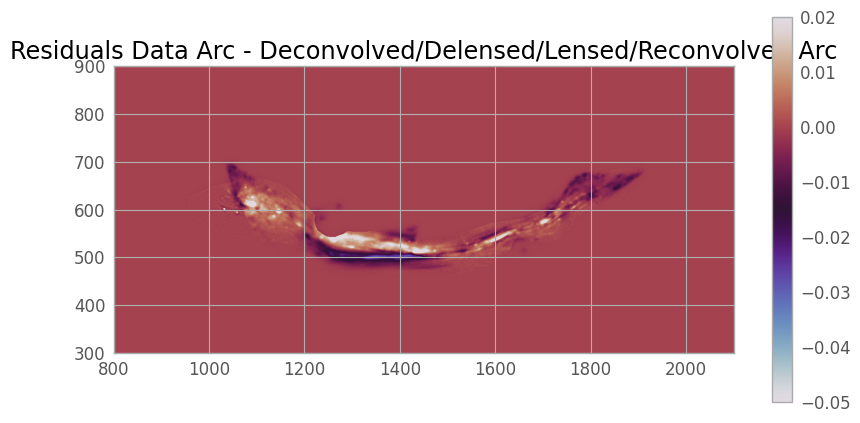

In [15]:
source_interp,img_model,left_im_arc_psf_conv = lens_delensedsource_to_image(output_file0='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/output0.fits',output_file1='/mnt/c/Users/lana-/Desktop/Min_Max_Tests/output0.fits')#,mag_yes=1)

RUN ALL

In [ ]:
data_arc_left, deconvolved_RL = deconvolve_data_im()
#do this for 25
for ind in range(25):

    #now need to mask the arc
    zero_masks = 1.*deconvolved_RL
    arc_to_mask = 1.*deconvolved_RL
    #rectangle
    for p in range(340):
        for q in range(180):
            zero_masks[q+520][p+920] = 50000000.
    arc_to_mask[numpy.where(zero_masks!=50000000.)] = numpy.nan


    arc_interp, src_model = delens_left_image_to_source(indx=ind,method_delens=1)


    #mask the source now
    zero_masks = 1.*src_model
    source_to_mask = 1.*src_model
    #set up indices where do not want
    for p in range(150):
        for q in range(125):
            zero_masks[q+1000][p+1200] = 50000000.
    #edit the source map to include only the region that we want to use
    source_to_mask[numpy.where(src_model==0.)] = numpy.nan


    source_interp,img_model,left_im_arc_psf_conv = lens_delensedsource_to_image(indx=ind)

#need to label plots with the indices